In [1]:
#Importing libraries

import pandas as pd
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.ensemble import RandomForestClassifier
import pickle
from sklearn.naive_bayes import BernoulliNB
from imblearn.over_sampling import SMOTE
import joblib
import os
from sklearn import svm
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
import warnings
from sklearn.metrics import roc_auc_score
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate

In [2]:
#Downloading dataframes

df_sessions = pd.read_csv('/home/nikitazuev/git/sber_autosubscribe/final_project/data/ga_sessions.csv', low_memory=False)
df_hits = pd.read_csv('/home/nikitazuev/git/sber_autosubscribe/final_project/data/ga_hits.csv')

In [3]:
df_sessions.head() # dataset shows parameters of user session

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow


In [4]:
df_hits.head() # dataset shows certain event per session (many sessions but one event)

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,NaN
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,NaN


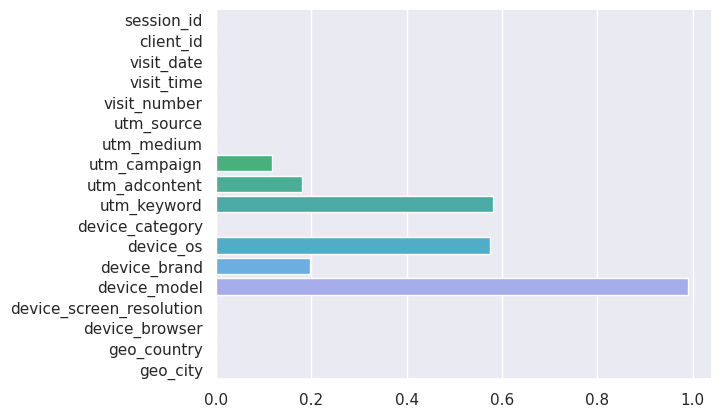

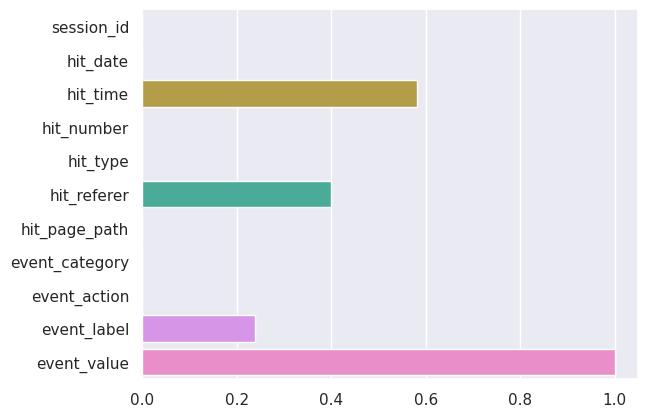

In [5]:
#Checking percentage of NaN values per column

nan_sessions = df_sessions.isnull().sum()/df_sessions.shape[0]
nan_hits = df_hits.isnull().sum()/df_hits.shape[0]


#some columns have enormous amount of nan-values

sns.set(style="darkgrid")
sns.barplot(y=nan_sessions.index,x=nan_sessions,orient='h')
plt.show()
sns.barplot(y=nan_hits.index,x=nan_hits,orient='h')
plt.show()

In [6]:
##################################################DATA CLEANINING################################################
#Cleaning (deleting unnecessary columns and if they have more than 20% of NaN)

def delete_cols(df):
    if 'utm_keyword' in list(df.columns):
        unnecessary = ['visit_date','visit_time','visit_number','client_id','device_model','device_os','utm_keyword'] #last three are added 
        df.drop(unnecessary,axis=1,inplace=True)
    else:
        unnecessary = []
        for column in df.columns:
            if column!='session_id' and column!='event_action':
                unnecessary.append(column)
        df.drop(unnecessary,axis=1,inplace=True)
    if df.shape[0]>200000:
        for col in df.columns:
            if float(df[col].isnull().sum()/df.shape[0]) >= 0.2:
                del df[col]
    

In [7]:
delete_cols(df_sessions)
delete_cols(df_hits)

In [8]:
#Looking at the result

df_sessions.info(),df_hits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 11 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   session_id                object
 1   utm_source                object
 2   utm_medium                object
 3   utm_campaign              object
 4   utm_adcontent             object
 5   device_category           object
 6   device_brand              object
 7   device_screen_resolution  object
 8   device_browser            object
 9   geo_country               object
 10  geo_city                  object
dtypes: object(11)
memory usage: 156.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 2 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   session_id    object
 1   event_action  object
dtypes: object(2)
memory usage: 240.0+ MB


(None, None)

In [9]:
#Filling data
#Replacing remained NaN values (<20% in column) in columns with object type with the most frequent word, in discrete cols with mean
#all replacement values stores in certain files, so after processing of the raw row nan values could be replaced

def fill_data(df):
    obj_col = []
    num_col = []
    for col in df.columns:
        if df[col].dtype == 'object':
            obj_col.append(col)
        else:
            num_col.append(col)

    path ='/home/nikitazuev/git/sber_autosubscribe/final_project/fill_na/' 
    directory= os.listdir(path) 
    if len(directory) < 3:
        for null_col in num_col:
            df[null_col].fillna(int(df[null_col].mean()),inplace=True)
            filename = f'{path}{null_col}_fd.txt'
            filled_data = int(df[null_col].mean())
            with open(filename,'w') as f:
                f.write(str(filled_data))

        for null_col in obj_col:
            df[null_col].fillna(df[null_col].value_counts().idxmax(),inplace=True)
            filename = f'{path}{null_col}_fd.txt'
            filled_data = df[null_col].value_counts().idxmax()
            with open(filename,'w') as f:
                f.write(filled_data)
    else:
        cols = [col for col in df.columns]
        for col in cols:
            filename = f'{path}{col}_fd.txt'
            with open(filename) as f:    
                filled_data = f.read()
                if df[col].dtype == 'object': 
                    df[col].fillna(filled_data,inplace=True)
                else:
                    df[col].fillna((filled_data),inplace=True)

In [10]:
fill_data(df_sessions)

In [11]:
#checking the result

df_sessions.isnull().sum(),df_hits.isnull().sum()

(session_id                  0
 utm_source                  0
 utm_medium                  0
 utm_campaign                0
 utm_adcontent               0
 device_category             0
 device_brand                0
 device_screen_resolution    0
 device_browser              0
 geo_country                 0
 geo_city                    0
 dtype: int64,
 session_id      0
 event_action    0
 dtype: int64)

In [12]:
#Grouping df_hits

df_hits =  df_hits.groupby(['session_id']).max().reset_index()

In [13]:
#########################################FEATURE ENGINEERING##################################################

In [14]:
#Encoding categorical features

def ORD(df):
    obj_col = [col for col in df.columns if df[col].dtype == 'object']
    obj_col.pop(0)

    path ='/home/nikitazuev/git/sber_autosubscribe/final_project/encoders/' 
    directory= os.listdir(path) 
    if len(directory) < 3:
        for obj in obj_col:
            enc = LabelEncoder()
            enc.fit(df[[obj]])
            df[obj] = enc.transform(df[[obj]])
            filenam = f'{path}{obj}_encoder.bin'
            joblib.dump(enc, filenam)
    else:
        for obj in obj_col:
            enc = joblib.load(f'{path}{obj}_encoder.bin')
            df[obj] = enc.transform(df[[obj]])

In [15]:
ORD(df_sessions)

In [16]:
#Standartization

def STD(df):
    path ='/home/nikitazuev/git/sber_autosubscribe/final_project/scalers/' 
    directory= os.listdir(path) 
    num_col = [col for col in df.columns if df[col].dtype != 'object']
    if len(directory) == 0:
        for std_feature in num_col:
            std_scaler=StandardScaler()
            std_scaler.fit(df[[std_feature]])
            scaled=std_scaler.transform(df[[std_feature]])
            filenam = f'/home/nikitazuev/git/sber_autosubscribe/final_project/scalers/{std_feature}_scaler.bin'
            joblib.dump(std_scaler, filenam)
            df[f"{std_feature}"]=scaled
    else:
        for process in num_col:
            scaler = joblib.load(f'/home/nikitazuev/git/sber_autosubscribe/final_project/scalers/{process}_scaler.bin')
            scaled = scaler.transform(df[[process]])
            df[f"{process}"]=scaled

In [17]:
STD(df_sessions)

In [18]:
#Target column engineering, so it could be binary classification problem

target_list = ['sub_car_claim_click', 'sub_car_claim_submit_click',
'sub_open_dialog_click', 'sub_custom_question_submit_click',
'sub_call_number_click', 'sub_callback_submit_click', 'sub_submit_success',
'sub_car_request_submit_click']
df_hits['event_action'] = df_hits['event_action'].apply(lambda x: 1 if x in target_list else 0)
df_hits.event_action.unique()

array([0, 1])

In [19]:
#Saving final dataset 

df_sessions.merge(df_hits, on=['session_id'], how='inner').drop(columns=['session_id']).to_csv('/home/nikitazuev/git/sber_autosubscribe/final_project/data/final_df.csv',index=False)

In [20]:
##########################################MODELING#################################################################

In [21]:
final_df = pd.read_csv('/home/nikitazuev/git/sber_autosubscribe/final_project/data/final_df.csv')
final_df

,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,event_action
0,0.033661,-0.591232,-0.443622,2.040975,0.451891,-0.009964,-0.371761,-0.827775,0.05221,1.894256,0
1,-1.249171,0.143040,-0.965082,2.279139,0.451891,0.953660,0.212309,1.245055,0.05221,-0.096875,0
2,0.033661,-0.591232,-0.443622,2.040975,0.451891,-0.009964,-0.371761,-0.827775,0.05221,-0.671205,0
3,1.143137,0.061454,-0.408857,-0.227846,0.451891,1.560875,0.350477,-0.827775,0.05221,-0.096875,0
4,1.143137,0.061454,-0.408857,-0.516149,0.451891,1.560875,0.350477,-0.827775,0.05221,-0.096875,0
...,...,...,...,...,...,...,...,...,...,...,...
1732261,-2.532003,0.061454,-0.408857,-0.516149,-1.959596,-0.894385,-1.207044,-0.827775,0.05221,-0.096875,0
1732262,0.553728,-1.080747,-0.408857,-0.516149,0.451891,-0.894385,0.238477,1.146349,0.05221,1.178609,0
1732263,0.553728,-1.080747,-0.408857,-0.516149,0.451891,-0.894385,-0.082866,1.146349,0.05221,-0.096875,0
1732264,0.033661,-0.591232,-0.443622,-0.516149,0.451891,1.560875,0.417467,-0.827775,0.05221,-1.870594,0


In [22]:
#Separating features from target

X = final_df.drop(['event_action'],axis=1)
Y = final_df['event_action']
X,Y

(         utm_source  utm_medium  utm_campaign  utm_adcontent  device_category  \
 0          0.033661   -0.591232     -0.443622       2.040975         0.451891   
 1         -1.249171    0.143040     -0.965082       2.279139         0.451891   
 2          0.033661   -0.591232     -0.443622       2.040975         0.451891   
 3          1.143137    0.061454     -0.408857      -0.227846         0.451891   
 4          1.143137    0.061454     -0.408857      -0.516149         0.451891   
 ...             ...         ...           ...            ...              ...   
 1732261   -2.532003    0.061454     -0.408857      -0.516149        -1.959596   
 1732262    0.553728   -1.080747     -0.408857      -0.516149         0.451891   
 1732263    0.553728   -1.080747     -0.408857      -0.516149         0.451891   
 1732264    0.033661   -0.591232     -0.443622      -0.516149         0.451891   
 1732265    0.692412    0.143040     -0.965082       2.379418        -1.959596   
 
          devi

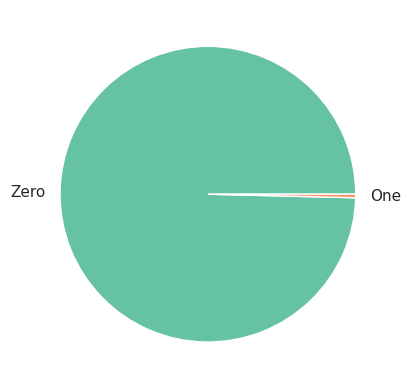

In [23]:
#Checking the ratio of values in target column, probably we need resampling

target_values = [len(Y[Y==0]),len(Y[Y==1])]
labels = ['Zero','One']
palette_color = sns.color_palette('Set2')
plt.pie(target_values,colors=palette_color,labels=labels)
plt.show()

In [24]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
sm = SMOTE(random_state=42)
x_train, y_train = sm.fit_resample(x_train, y_train)

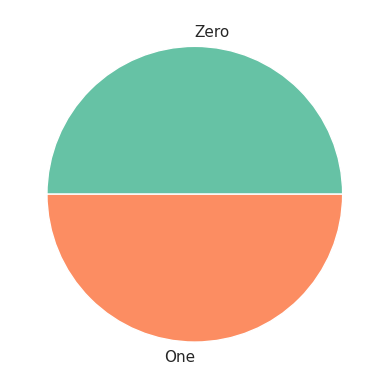

In [25]:
#Checking the result

target_values = [len(y_train[y_train==0]),len(y_train[y_train==1])]
labels = ['Zero','One']
palette_color = sns.color_palette('Set2')
plt.pie(target_values,colors=palette_color,labels=labels)
plt.show()

In [26]:
#Creating different models

lgr=LogisticRegression(max_iter = 1000) 
bern = BernoulliNB()
rfc = RandomForestClassifier(n_estimators=200, max_depth=3)
tree = tree.DecisionTreeClassifier() #high test_score, the roc_auc is needed to be checked
models = ['rfc','bern','tree','lgr'] 

In [27]:
#Finding the best model with cross-validation, detecting overfitting by checking test_scores and fit_time

for model in models:
    exec(f'print(cross_validate({model},x_train,y_train,cv=3))') 

{'fit_time': array([118.01544833, 115.82065225, 130.49437547]), 'score_time': array([6.07075453, 6.35601068, 6.14029455]), 'test_score': array([0.65708314, 0.65959081, 0.65849156])}
{'fit_time': array([0.78064847, 0.73714066, 0.73460031]), 'score_time': array([0.27522016, 0.26568508, 0.26298928]), 'test_score': array([0.57151901, 0.57075101, 0.5725031 ])}
{'fit_time': array([7.56813884, 8.78033853, 8.69026518]), 'score_time': array([0.20871425, 0.21897602, 0.21817374]), 'test_score': array([0.91594981, 0.91873379, 0.91913844])}
{'fit_time': array([1.67665839, 1.77062821, 1.76370788]), 'score_time': array([0.10267615, 0.19846773, 0.21080494]), 'test_score': array([0.56914108, 0.57069783, 0.57013943])}


In [28]:
for model in models: #tree model showed the best test_score, maybe it's the best model, but to be precise I will check roc_auc curve
    exec(f'{model}.fit(x_train,y_train)')

In [29]:
for model in models:
    exec(f'print(roc_auc_score(y_test, {model}.predict_proba(x_test)[:, 1]))')

0.671978765281235
0.5999721062897326
0.6049129258483736
0.5894169760108212


In [30]:
#The tree predicts more accurate but it seems that it has no logic in it's decisions, that's why I'm saving rfc

filename='/home/nikitazuev/git/sber_autosubscribe/final_project/model/final_model.pickle'
with open(filename,'wb') as file:
    pickle.dump(rfc, file)

In [31]:
#Just last check, again, on the raw data.

def pipeline(df):
    delete_cols(df)
    fill_data(df)
    ORD(df)
    STD(df)


for i in range(5):
    with open(filename,'rb') as file:
        session = pd.read_csv('/home/nikitazuev/git/sber_autosubscribe/final_project/data/ga_sessions.csv', low_memory=False).iloc[i].to_frame().T
        pipeline(session)
        final_session = session.drop(columns=['session_id'])
        rfc = pickle.load(file)
        print(rfc.predict(final_session))

[0]
[1]
[0]
[1]
[1]
